In [38]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

%pip install torchmetrics
from torchmetrics.functional import accuracy, precision, recall, f1_score
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

%pip install torch.onnx

In [16]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Hyperparameters

In [17]:
epoch = 50
batch_size = 32
num_workers = 2
shuffle = True
learning_rate = 0.005
train_size = 50000
val_size = 10000
test_size = 10000

# Custom Model

In [18]:
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv2d(1, 32, 5, padding="same")
        self.batch_norm1 = nn.BatchNorm2d(32)

        self.layer2 = nn.Conv2d(32, 64, 5, padding="same")
        self.batch_norm2 = nn.BatchNorm2d(64)

        self.layer3 = nn.Linear(3136, 512)
        self.batch_norm3 = nn.BatchNorm1d(512)

        self.layer4 = nn.Linear(512, 128)
        self.batch_norm4 = nn.BatchNorm1d(128)

        self.layer5 = nn.Linear(128, 32)
        self.batch_norm5 = nn.BatchNorm1d(32)

        self.output = nn.Linear(32, 10)

    def forward(self, x):
        x = F.max_pool2d(
            F.relu(self.batch_norm1(self.layer1(x))), kernel_size=2, stride=2
        )
        x = F.max_pool2d(
            F.relu(self.batch_norm2(self.layer2(x))), kernel_size=2, stride=2
        )
        x = x.view(-1, 3136)
        x = F.relu(self.batch_norm3(self.layer3(x)))
        x = F.relu(self.batch_norm4(self.layer4(x)))
        x = F.relu(self.batch_norm5(self.layer5(x)))
        x = self.output(x)
        return x

In [19]:
dataset = MNIST(root="", download=True)
# Random_split can take both subclass of Dataset or np.ndarray etc anything.
train_dataset, val_dataset = random_split(dataset, [50000, 10000])

test_dataset = MNIST(root="", train=False, download=True)

In [20]:
# Custom collate is required here as we have images as PIL.Image.Image object.
# These can't be directly converted to tensor, We have to use do it via np.ndarray
# Tensor returned here are mounted on GPU (assuming VRAM will have enough to store the data in gpu)
def custom_collate(
    batch,
):
    """This is custom collate function"""
    imgs = torch.tensor(
        np.array([[idv_data[0]] for idv_data in batch]), dtype=torch.float32
    )
    label = torch.tensor([idv_data[1] for idv_data in batch], dtype=torch.int64)
    return imgs, label

# Training dataloader

In [21]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers,
    collate_fn=custom_collate,
    pin_memory=True,
)

# Training dataloader for evaluation metrices(without batching)

In [22]:
train_eval_imgs = torch.tensor(
    np.array([[train_dataset[i][0]] for i in range(len(train_dataset))]),
    dtype=torch.float32, device=device
)
train_eval_labels = torch.tensor(
    [train_dataset[i][1] for i in range(len(train_dataset))], dtype=torch.int64, device=device
)
train_eval_dataloader = (train_eval_imgs, train_eval_labels)
train_eval_dataloader[0].shape

torch.Size([50000, 1, 28, 28])

# Validation dataloader for evaluation metrices(without batching)

In [23]:
val_imgs = torch.tensor(
    np.array([[val_dataset[i][0]] for i in range(len(val_dataset))]), dtype=torch.float32, device=device
)
val_labels = torch.tensor(
    [val_dataset[i][1] for i in range(len(val_dataset))], dtype=torch.int64, device=device
)
val_dataloader = (val_imgs, val_labels)

# Evaluation Class

In [24]:
class Metrices:
    def __init__(self):
        self.accuracy = 0
        self.recall = 0
        self.f1_score = 0
        self.precision = 0

        self.accuracy_list = []
        self.precision_list = []
        self.f1_score_list = []
        self.recall_list = []

    def __call__(self, y_pred, y_true):
        # As here each class label has equal weightage so type of average taken is macro.
        self.accuracy = accuracy(
            y_pred, y_true, task="multiclass", num_classes=10, average="macro"
        ).item()
        self.precision = precision(
            y_pred, y_true, task="multiclass", num_classes=10, average="macro"
        ).item()
        self.f1_score = f1_score(
            y_pred, y_true, task="multiclass", num_classes=10, average="macro"
        ).item()
        self.recall = recall(
            y_pred, y_true, task="multiclass", num_classes=10, average="macro"
        ).item()

        self.accuracy_list.append(self.accuracy)
        self.precision_list.append(self.precision)
        self.f1_score_list.append(self.f1_score)
        self.recall_list.append(self.recall)

In [26]:
no_of_pixels = 784
train_metrices = Metrices()
val_metrices = Metrices()

criterion = nn.CrossEntropyLoss()
model = CustomModel()
model.to(device)
optimizer = torch.optim.Adam(model.parameters())

# Training loop

In [27]:
for cur_epoch in range(epoch):
    for batch_x, batch_y_true in train_dataloader:
        model.train()
        batch_x = batch_x.to(device)
        batch_y_true = batch_y_true.to(device)
        batch_y_pred = model(batch_x)
        # batch_y_true is 1D and batch_y_pred 2D shape(batch_size,10).
        loss = criterion(
            batch_y_pred,
            batch_y_true,
        )
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f"\nEpoch [{cur_epoch+1}/{epoch}], Loss: {loss}")

    with torch.no_grad():
        model.eval()
        train_eval_x = train_eval_dataloader[0].to(device)
        train_eval_y_pred = model(train_eval_x)
        train_eval_y_true = train_eval_dataloader[1].to(device)
        train_metrices(train_eval_y_pred, train_eval_y_true)
        print("Train metrices:")
        print(
            f"Accuracy: {train_metrices.accuracy:.5f}, Precision: {train_metrices.precision:.5f}, Recall: {train_metrices.recall:.5f}, F1_Score: {train_metrices.f1_score:.5f}"
        )

        val_x = val_dataloader[0].to(device)
        val_y_pred = model(val_x)
        val_y_true = val_dataloader[1].to(device)
        val_metrices(val_y_pred, val_y_true)
        print("Validation metrices:")
        print(
            f"Accuracy: {val_metrices.accuracy:.5f}, Precision: {val_metrices.precision:.5f}, Recall: {val_metrices.recall:.5f}, F1_Score: {val_metrices.f1_score:.5f}"
        )


Epoch [1/50], Loss: 0.2246055006980896
Train metrices:
Accuracy: 0.98609, Precision: 0.98643, Recall: 0.98609, F1_Score: 0.98619
Validation metrices:
Accuracy: 0.98221, Precision: 0.98252, Recall: 0.98221, F1_Score: 0.98228

Epoch [2/50], Loss: 0.08637355268001556
Train metrices:
Accuracy: 0.98954, Precision: 0.98957, Recall: 0.98954, F1_Score: 0.98951
Validation metrices:
Accuracy: 0.98461, Precision: 0.98457, Recall: 0.98461, F1_Score: 0.98448

Epoch [3/50], Loss: 0.004200121387839317
Train metrices:
Accuracy: 0.99454, Precision: 0.99459, Recall: 0.99454, F1_Score: 0.99456
Validation metrices:
Accuracy: 0.98859, Precision: 0.98858, Recall: 0.98859, F1_Score: 0.98855

Epoch [4/50], Loss: 0.005421239882707596
Train metrices:
Accuracy: 0.99501, Precision: 0.99499, Recall: 0.99501, F1_Score: 0.99498
Validation metrices:
Accuracy: 0.99058, Precision: 0.99079, Recall: 0.99058, F1_Score: 0.99067

Epoch [5/50], Loss: 0.0005778963095508516
Train metrices:
Accuracy: 0.99696, Precision: 0.9969

# Training and Validation Plots

Text(0.5, 1.0, 'Metrices vs Epoch')

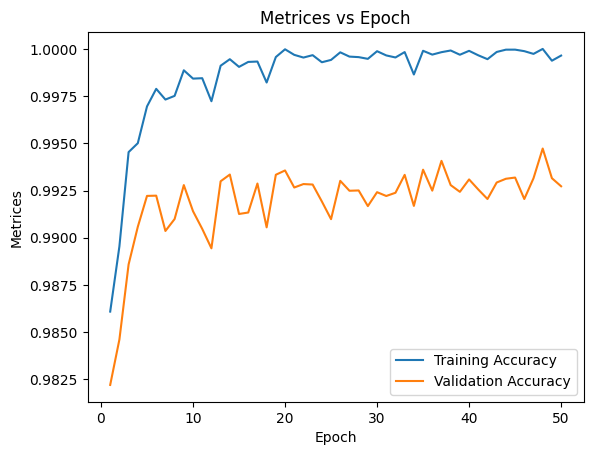

In [28]:
plt.plot(range(1, epoch + 1), train_metrices.accuracy_list, label="Training Accuracy")
plt.plot(range(1, epoch + 1), val_metrices.accuracy_list, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Metrices")
plt.legend()
plt.title("Metrices vs Epoch")

Text(0.5, 1.0, 'Metrices vs Epoch')

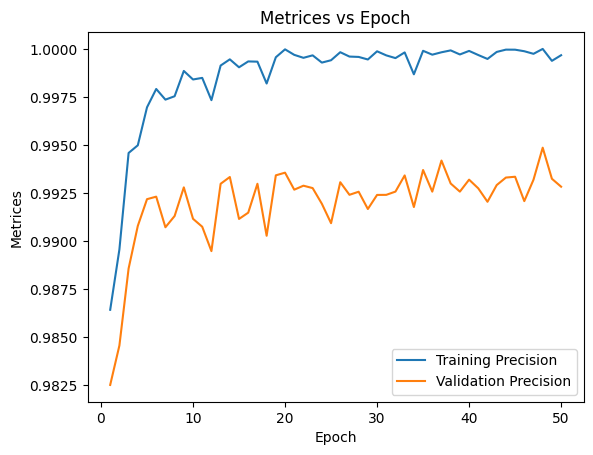

In [29]:
plt.plot(range(1, epoch + 1), train_metrices.precision_list, label="Training Precision")
plt.plot(range(1, epoch + 1), val_metrices.precision_list, label="Validation Precision")
plt.xlabel("Epoch")
plt.ylabel("Metrices")
plt.legend()
plt.title("Metrices vs Epoch")

Text(0.5, 1.0, 'Metrices vs Epoch')

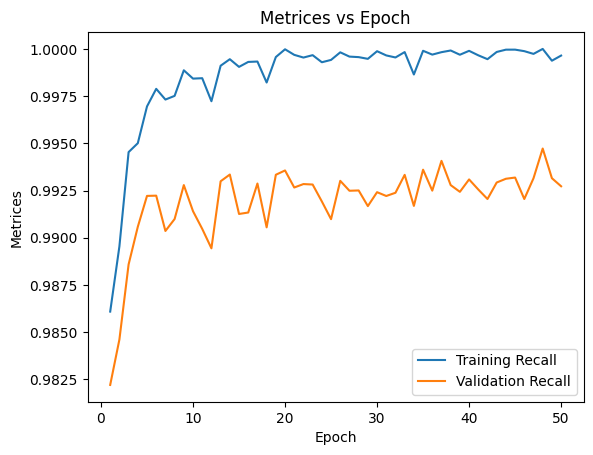

In [31]:
# Here recall is equal to accuracy as in MNIST dataset no of occurances of each class is same
plt.plot(range(1, epoch + 1), train_metrices.recall_list, label="Training Recall")
plt.plot(range(1, epoch + 1), val_metrices.recall_list, label="Validation Recall")
plt.xlabel("Epoch")
plt.ylabel("Metrices")
plt.legend()
plt.title("Metrices vs Epoch")

Text(0.5, 1.0, 'Metrices vs Epoch')

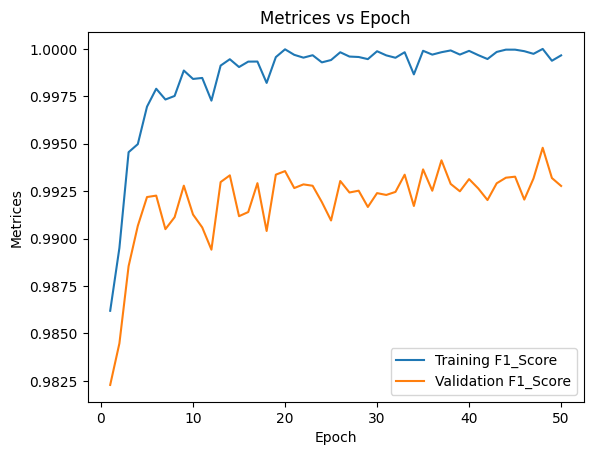

In [32]:
plt.plot(range(1, epoch + 1), train_metrices.f1_score_list, label="Training F1_Score")
plt.plot(range(1, epoch + 1), val_metrices.f1_score_list, label="Validation F1_Score")
plt.xlabel("Epoch")
plt.ylabel("Metrices")
plt.legend()
plt.title("Metrices vs Epoch")

# Final Evaluation on test dataset

In [33]:
test_imgs = torch.tensor(
    np.array([[test_dataset[i][0]] for i in range(len(test_dataset))], dtype=np.float32), device=device
)
test_labels = torch.tensor(
    [test_dataset[i][1] for i in range(len(test_dataset))], dtype=torch.int64, device=device
)
test_dataloader = (test_imgs, test_labels)

In [43]:
test_x = test_dataloader[0]
%pip install torch.onnx
torch.onnx.export(
    model,
    test_x,
    "model.onnx",
    export_params=True,
    opset_version=10,
    do_constant_folding=False,
    input_names=["input"],
    output_names=["output"],
)

In [44]:
with torch.no_grad():
    model.eval()
    test_x = test_dataloader[0]
    test_y_pred = model(test_x)
    test_y_true = test_dataloader[1]
    test_metrices = Metrices()
    test_metrices(test_y_pred, test_y_true)
    print("\nFinal Evaluation Metrices:")
    print(
        f"Accuracy: {test_metrices.accuracy:.5f}, Precision: {test_metrices.precision:.5f}, F1_Score: {test_metrices.f1_score:.5f}, Recall: {test_metrices.recall:.5f}"
    )


Final Evaluation Metrices:
Accuracy: 0.99390, Precision: 0.99410, F1_Score: 0.99399, Recall: 0.99390
